In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
from algorithms import *
from data_gen import *
from spectrum_gen import *
from visualizations import *
from analysis import *



In [2]:
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2


In [5]:
def inner_product_genes_scn(cluster, gene1, gene2):
    adata_raw = sc.read("SCN/" + cluster + "_raw" + ".h5ad")
    adata_en = sc.read("SCN/" + cluster + "_en" + ".h5ad")
    gene1_raw = np.array(adata_raw[:,gene1].X[:,0])
    gene2_raw = np.array(adata_raw[:,gene2].X[:,0])
    gene1_en = np.array(adata_en[:,gene1].X[:,0])
    gene2_en = np.array(adata_en[:,gene2].X[:,0])
    gene1_raw = (gene1_raw - gene1_raw.mean())# / gene1_raw.std()
    gene2_raw = (gene2_raw - gene2_raw.mean())# / gene2_raw.std()
    gene1_raw = gene1_raw/ np.linalg.norm(gene1_raw)
    gene2_raw = gene2_raw/ np.linalg.norm(gene2_raw)
    gene1_en = (gene1_en - gene1_en.mean()) #/ gene1_en.std()
    gene2_en = (gene2_en - gene2_en.mean()) #/ gene2_en.std()
    gene1_en = gene1_en/ np.linalg.norm(gene1_en)
    gene2_en = gene2_en/ np.linalg.norm(gene2_en)
    print("Enhanced inner product: " +str(gene1_en.dot(gene2_en)))
    print("Raw inner product: " +str(gene1_raw.dot(gene2_raw)))
    return gene1_en.dot(gene2_en), gene1_raw.dot(gene2_raw)

In [72]:
def grn_cluster(cluster):
    ''' '''
    adata = sc.read("SCN/" + cluster+"_en" +".h5ad")
    ge = np.array(adata.X)
    genes = adata.var_names
    network = grnboost2(expression_data=ge,
                        gene_names=genes)#,  # specify the gene_names
    network.to_csv(cluster +'_en.tsv', sep='\t', index=False, header=False)
    print("en done")
    adata = sc.read("SCN/" + cluster+"_raw" +".h5ad")
    ge = np.array(adata.X)
    genes = adata.var_names
    network = grnboost2(expression_data=ge,
                        gene_names=genes)#,  # specify the gene_names
    network.to_csv(cluster +'_raw.tsv', sep='\t', index=False, header=False)
    pass

def calculate_known_network_score(cluster,network_en,network_raw):
    '''Calculate the score (by GRNBoost2) of a known regulatory network (circadian rhythm network)'''
    relation_list =[
    ]
    Per2 = ['Per1','Per2','Per3']
    Cry1 = ['Cry1','Cry2']
    nr_group= ['Nr1d1','Nr1d2','Rora','Rorb','Rorc']
    Bmal = ['Arntl','Npas2']
    Dbp_group= ['Dbp'',Hlf','Tef','E4bp4']
    for item in nr_group:
        for item2 in Per2:
            relation_list.append((item2,item))
        for item2 in Cry1:
            relation_list.append((item2,item))
            relation_list.append((item,item2))
        for item2 in Dbp_group:
                relation_list.append((item2,item))
        for item2 in Bmal:
                relation_list.append((item,item2))
                relation_list.append((item2,item))
    for item in Dbp_group:
        for item2 in Per2:
            relation_list.append((item2,item))
            relation_list.append((item,item2))
        for item2 in Cry1:
            relation_list.append((item2,item))
            relation_list.append((item,item2))
        for item2 in Bmal:
                relation_list.append((item2,item))
    for item in Bmal:
        for item2 in Per2:
            relation_list.append((item,item2))
        for item2 in Cry1:
            relation_list.append((item,item2))
    for item in Per2:
        for item2 in Cry1:
            relation_list.append((item2,item))
            relation_list.append((item,item2))
    raw_sum=0
    en_sum =0
    for item in relation_list:
        if item[0] in network_en['TF'].values:
                tmp_row = network_en.loc[((network_en['TF'] == item[0])) ]
                if item[1] in tmp_row['target'].values:
                    tmp_row = tmp_row.loc[((tmp_row['target'] == item[1])) ]
                    en_sum+=float(tmp_row['importance'])
    for item in relation_list:
        if item[0] in network_raw['TF'].values:
                tmp_row = network_raw.loc[((network_raw['TF'] == item[0])) ]
                if item[1] in tmp_row['target'].values:
                    tmp_row = tmp_row.loc[((tmp_row['target'] == item[1])) ]
                    raw_sum+=float(tmp_row['importance'])
    print( " Raw data score: " + str(raw_sum) )
    print( " Enhanced data score: " + str(en_sum) )


In [23]:
cluster= 'Astrocytes'
adata = sc.read("SCN/" + cluster+"_en" +".h5ad")
adata.X.shape

cluster= 'Ependymal'
adata = sc.read("SCN/" + cluster+"_en" +".h5ad")
ge = np.array(adata.X)
genes = adata.var_names
genes

inner_product_genes_scn('Ependymal','0610009L18Rik','Fibp')
plt_mean_gene('Ependymal','0610009L18Rik',up_lim=1, down_lim=-0.05)
plt_mean_gene('Ependymal','Fibp',up_lim=0.5, down_lim=-0.05)


inner_product_genes_scn('Ependymal','Hsp90ab1','Hspa5')
plt_mean_gene('Ependymal','Hsp90ab1',up_lim=6.7, down_lim=-0.05)
plt_mean_gene('Ependymal','Hspa5',up_lim=6.7, down_lim=-0.05)

inner_product_genes_scn('Ependymal','Nr1d2','Dbp')
plt_mean_gene('Ependymal','Nr1d2',up_lim=1, down_lim=-0.05)
plt_mean_gene('Ependymal','Dbp',up_lim=2, down_lim=-0.05)


cluster= 'Endothelial'
adata = sc.read("SCN/" + cluster+"_raw" +".h5ad")
ge = np.array(adata.X)
genes = adata.var_names
network_Endothelial_raw = grnboost2(expression_data=ge,
                        gene_names=genes)#,  # specify the gene_names
                        #tf_names=tf_names)

cluster= 'Endothelial'
adata = sc.read("SCN/" + cluster+"_en" +".h5ad")
ge = np.array(adata.X)
genes = adata.var_names
network_Endothelial_en = grnboost2(expression_data=ge,
                        gene_names=genes)#,  # specify the gene_names
                        #tf_names=tf_names)


network_Endothelial_en.to_csv('network_Endothelial_en.tsv', sep='\t', index=False, header=False)

network_Endothelial_en

network_Endothelial_raw

inner_product_genes_scn('Ependymal','Dbp','Per1')
plt_mean_gene('Ependymal','Dbp',up_lim=2, down_lim=-0.05)
plt_mean_gene('Ependymal','Per1',up_lim=0.5, down_lim=-0.05)

inner_product_genes_scn('Endothelial','Hba-a1','Hba-a2')
plt_mean_gene('Endothelial','Hba-a1',up_lim=0.7, down_lim=-0.05)
plt_mean_gene('Endothelial','Hba-a2',up_lim=0.7, down_lim=-0.05)

(1451, 3018)

In [2]:
cluster= 'Ependymal'
adata = sc.read("SCN/" + cluster+"_en" +".h5ad")
ge = np.array(adata.X)
genes = adata.var_names
genes

network = grnboost2(expression_data=ge,
                        gene_names=genes)#,  # specify the gene_names
                        #tf_names=tf_names)
network

In [59]:
cluster= 'Endothelial'
adata = sc.read("SCN/" + cluster+"_raw" +".h5ad")
ge = np.array(adata.X)
genes = adata.var_names
network_Endothelial_raw = grnboost2(expression_data=ge,
                        gene_names=genes)#,  # specify the gene_names
                        #tf_names=tf_names)

cluster= 'Endothelial'
adata = sc.read("SCN/" + cluster+"_en" +".h5ad")
ge = np.array(adata.X)
genes = adata.var_names
network_Endothelial_en = grnboost2(expression_data=ge,
                        gene_names=genes)#,  # specify the gene_names
                        #tf_names=tf_names)


In [142]:

    
def calculate_single_cr_network(network):
    Dbp_group= ['Dbp'',Hlf','Tef','E4bp4']
    nr_group= ['Nr1d1','Nr1d2','Rora','Rorb','Rorc']
    Per2 = ['Per1','Per2','Per3']
    Cry1 = ['Cry1','Cry2']
    Bmal = ['Arntl','Npas2']
    sum_score=0
    for dbp_item in Dbp_group:
        for nr_item in nr_group:
            if dbp_item in network['TF'].values:
                tmp_row = network.loc[((network['TF'] == dbp_item)) ]
                if nr_item in tmp_row['target'].values:
                    tmp_row = tmp_row.loc[((tmp_row['target'] == nr_item)) ]
                    sum_score+=float(tmp_row['importance'])
                

    raw_sum=0
    en_sum =0
    for item in relation_list:
        if item[0] in network_en['TF'].values:
                tmp_row = network_en.loc[((network_en['TF'] == item[0])) ]
                if item[1] in tmp_row['target'].values:
                    print(item[1])
                    tmp_row = tmp_row.loc[((tmp_row['target'] == item[1])) ]
                    en_sum+=float(tmp_row['importance'])
    for item in relation_list:
        if item[0] in network_raw['TF'].values:
                tmp_row = network_raw.loc[((network_raw['TF'] == item[0])) ]
                if item[1] in tmp_row['target'].values:
                    tmp_row = tmp_row.loc[((tmp_row['target'] == item[1])) ]
                    raw_sum+=float(tmp_row['importance'])
    print(raw_sum)
    print(en_sum)
calculate_known_network_score(1,network_Endothelial_en,network_Endothelial_raw)

('Per1', 'Nr1d1') en 0.8049951098188229
('Tef', 'Nr1d1') en 0.12459092654275156
('Per1', 'Nr1d2') en 3.6066392780809267
('Tef', 'Nr1d2') en 0.44374156917921126
('Per1', 'Tef') en 0.11767633515685633
('Tef', 'Per1') raw 0.0002459663761784523
 Raw data score: 0.0002459663761784523
 Enhanced data score: 5.097643218778569


True

In [155]:
def network_grn(cluster):
    adata = sc.read("SCN/" + cluster+"_en" +".h5ad")
    ge = np.array(adata.X)
    genes = adata.var_names
    df = pd.read_csv("Mus_musculus_TF.txt", '\t')
    list_of_tf = list(df['Symbol'].values)
    list_of_tf = [x for x in list_of_tf if x in adata.var_names]
    network = grnboost2(expression_data=ge,
                            gene_names=genes,  # specify the gene_names
                            tf_names=list_of_tf)
    network.to_csv('SCN/' + cluster + '_netowrk_en_tf.csv')  
    print("en done")
    adata = sc.read("SCN/" + cluster+"_raw" +".h5ad")
    ge = np.array(adata.X)
    genes = adata.var_names
    list_of_tf = list(df['Symbol'].values)
    list_of_tf = [x for x in list_of_tf if x in adata.var_names]
    network = grnboost2(expression_data=ge,
                            gene_names=genes,  # specify the gene_names
                            tf_names=list_of_tf)
    network.to_csv('SCN/' + cluster + '_netowrk_raw_tf.csv')  
    print(cluster + " done")
    pass


In [185]:
def filtered_network_grn(cluster):
    adata = sc.read("SCN/" + cluster+"_filtered" +".h5ad")
    ge = np.array(adata.X)
    genes = adata.var_names
    df = pd.read_csv("Mus_musculus_TF.txt", '\t')
    list_of_tf = list(df['Symbol'].values)
    list_of_tf = [x for x in list_of_tf if x in adata.var_names]
    network = grnboost2(expression_data=ge,
                            gene_names=genes,  # specify the gene_names
                            tf_names=list_of_tf)
    network.to_csv('SCN/' + cluster + '_netowrk_filtered_tf.csv')  
    pass


In [157]:
cluster1 = [
    'Ependymal',
    'NG2',
    'Endothelial',
    'Astrocytes',
    'Microglia',
    'Tanycytes',
    'Oligodendrocytes',
    'Neurons2']
cluster1 = [
    'Oligodendrocytes',
    'Neurons2']

for cluster in cluster1:
    print(cluster)
    network_grn(cluster)


Oligodendrocytes


<ipython-input-157-2359b9100bcf>:16: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  network_grn(cluster)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52656 instead
  warnings.warn(


en done


/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53431 instead
  warnings.warn(


Oligodendrocytes done
Neurons2


<ipython-input-157-2359b9100bcf>:16: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  network_grn(cluster)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53505 instead
  warnings.warn(


en done


/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53660 instead
  warnings.warn(


Neurons2 done


In [186]:
cluster1 = [
    'Ependymal',
    'NG2',
    'Endothelial',
    'Astrocytes',
    'Microglia',
    'Tanycytes',
    'Oligodendrocytes',
    'Neurons2']

for cluster in cluster1:
    print(cluster)
    filtered_network_grn(cluster)



Ependymal


<ipython-input-186-c396fb4c2d00>:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  filtered_network_grn(cluster)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54295 instead
  warnings.warn(


NG2


<ipython-input-186-c396fb4c2d00>:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  filtered_network_grn(cluster)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54348 instead
  warnings.warn(


Endothelial


<ipython-input-186-c396fb4c2d00>:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  filtered_network_grn(cluster)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54392 instead
  warnings.warn(


Astrocytes


<ipython-input-186-c396fb4c2d00>:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  filtered_network_grn(cluster)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54469 instead
  warnings.warn(


Microglia


<ipython-input-186-c396fb4c2d00>:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  filtered_network_grn(cluster)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54540 instead
  warnings.warn(


Tanycytes


<ipython-input-186-c396fb4c2d00>:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  filtered_network_grn(cluster)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54592 instead
  warnings.warn(


Oligodendrocytes


<ipython-input-186-c396fb4c2d00>:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  filtered_network_grn(cluster)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54637 instead
  warnings.warn(


Neurons2


<ipython-input-186-c396fb4c2d00>:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  filtered_network_grn(cluster)
/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54688 instead
  warnings.warn(


In [154]:
cluster1 = [
    'Ependymal',
    'NG2',
    'Endothelial',
    'Astrocytes',
    'Microglia',
    'Tanycytes',
    'Oligodendrocytes',
    'Neurons2']

cluster1 = ['Neurons2']
for cluster in cluster1:
    network_en = pd.read_csv('SCN/' + cluster + '_netowrk_en_tf.csv')  
    network_raw = pd.read_csv('SCN/' + cluster + '_netowrk_raw_tf.csv')  
    print(cluster)
    calculate_known_network_score(cluster,network_en,network_raw)



FileNotFoundError: [Errno 2] No such file or directory: 'SCN/Neurons2_netowrk_en_tf.csv'

In [126]:
cluster1 = [
    'Oligodendrocytes',
    'Neurons1']

for cluster in cluster1:
    print(cluster)
    network_grn(cluster)


Oligodendrocytes
en done
Oligodendrocytes done
Neurons1
en done
Neurons1 done


In [137]:
cluster1 = [
    'Neurons2']

for cluster in cluster1:
    print(cluster)
    network_grn(cluster)


Neurons2


/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 49946 instead
  warnings.warn(
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


en done


/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50316 instead
  warnings.warn(
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


Neurons2 done


Enhanced inner product: 0.17401011707728753
Raw inner product: 0.05897295


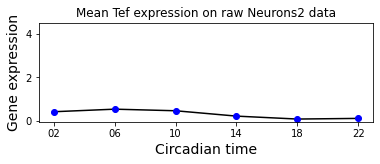

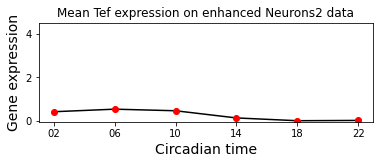

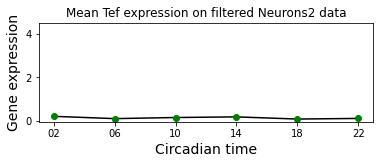

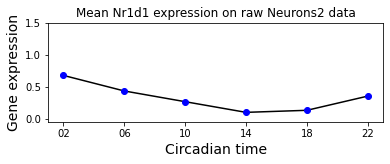

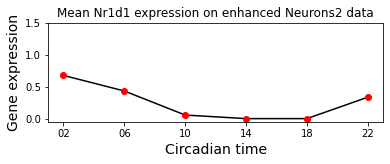

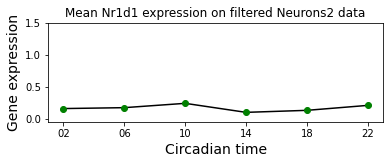

In [165]:
inner_product_genes_scn('Neurons2','Tef','Rorb')
plt_mean_gene('Neurons2','Tef',up_lim=4.5, down_lim=-0.05)
plt_mean_gene('Neurons2','Nr1d1',up_lim=1.5, down_lim=-0.05)

In [150]:
cluster = 'Neurons2'
adata = sc.read("SCN/" + cluster+"_en" +".h5ad")
ge = np.array(adata.X)
genes = adata.var_names
network = grnboost2(expression_data=ge,
                            gene_names=genes)#,  # specify the gene_names
                            #tf_names=tf_names)
network.to_csv('SCN/' + cluster + '_netowrk_en.csv')  


/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50592 instead
  warnings.warn(
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


In [152]:
df = pd.read_csv("Mus_musculus_TF.txt", '\t')
df['Symbol'].values

/Users/jonathankarin/.conda/envs/project/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


array(['Zfp146', 'Ets1', 'Mxd3', ..., 'Lyar', 'Cenps', 'Purb'],
      dtype=object)

Ependymal
 Raw data score: 0.8256491157226264
 Enhanced data score: 1.4436748884330672
Endothelial
 Raw data score: 0.5345728285610676
 Enhanced data score: 0.9044927305286904
Astrocytes
 Raw data score: 0.37794045079499483
 Enhanced data score: 0.6228624368517667
Microglia
 Raw data score: 0.5344337541610003
 Enhanced data score: 0.6109914466970265
Oligodendrocytes
 Raw data score: 0.3854842521250248
 Enhanced data score: 0.45537022335972444
NG2
 Raw data score: 0.39578616118524224
 Enhanced data score: 0.45476134100405624
Neurons2
 Raw data score: 1.5532474089413881
 Enhanced data score: 2.4763503305297654


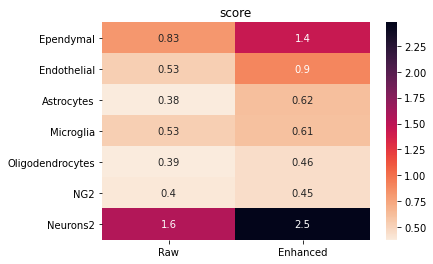

In [65]:
def calculate_known_network_adata(cluster):
    relation_list =[
    ]
    Per2 = ['Per1','Per2','Per3']
    Cry1 = ['Cry1','Cry2']
    nr_group= ['Nr1d1','Nr1d2','Rora','Rorb','Rorc']
    Bmal = ['Arntl','Npas2']
    Dbp_group= ['Dbp'',Hlf','Tef','E4bp4']
    for item in nr_group:
        for item2 in Per2:
            relation_list.append((item2,item))
        for item2 in Cry1:
            relation_list.append((item2,item))
            relation_list.append((item,item2))
        for item2 in Dbp_group:
                relation_list.append((item2,item))
        for item2 in Bmal:
                relation_list.append((item,item2))
                relation_list.append((item2,item))
    for item in Dbp_group:
        for item2 in Per2:
            relation_list.append((item2,item))
            relation_list.append((item,item2))
        for item2 in Cry1:
            relation_list.append((item2,item))
            relation_list.append((item,item2))
        for item2 in Bmal:
                relation_list.append((item2,item))
    for item in Bmal:
        for item2 in Per2:
            relation_list.append((item,item2))
        for item2 in Cry1:
            relation_list.append((item,item2))
    for item in Per2:
        for item2 in Cry1:
            relation_list.append((item2,item))
            relation_list.append((item,item2))
    raw_sum=0
    en_sum =0
    adata_en = sc.read('SCN/' + cluster + '_en.h5ad')  
    adata_raw = sc.read('SCN/' + cluster + '_raw.h5ad')  

    for item in relation_list:
        if item[0] in adata_en.var_names:
                if item[1] in adata_en.var_names:
                    tmp_gene_1 = np.array(adata_en[:,item[0]].X[:,0])
                    tmp_gene_2 = np.array(adata_en[:,item[1]].X[:,0])
                    en_sum+=float(inner_product_genes_scn_normalized(tmp_gene_1,tmp_gene_2))
    for item in relation_list:
        if item[0] in adata_raw.var_names:
                if item[1] in adata_raw.var_names:
                    tmp_gene_1 = np.array(adata_raw[:,item[0]].X[:,0])
                    tmp_gene_2 = np.array(adata_raw[:,item[1]].X[:,0])
                    raw_sum+=float(inner_product_genes_scn_normalized(tmp_gene_1,tmp_gene_2))
    print( " Raw data score: " + str(raw_sum) )
    print( " Enhanced data score: " + str(en_sum) )
    return raw_sum , en_sum
cluster_list = [
    'Ependymal',
    'NG2',
    'Endothelial',
    'Astrocytes',
    'Microglia',
    'Oligodendrocytes',
    'Neurons2']
cluster_list = [
    'Ependymal',
    'Endothelial',
    'Astrocytes',
    'Microglia',
    'Oligodendrocytes',
     'NG2',
    'Neurons2']

raw_list = [
]
en_list = []
for cluster in cluster_list:
    print(cluster)
    raw_sum , en_sum = calculate_known_network_adata(cluster)#,network_en,network_raw)
    raw_list.append(raw_sum)
    en_list.append(en_sum)

dat = np.array([raw_list,en_list])
dat = dat.T
df = pd.DataFrame(dat, index=cluster_list  , columns=['Raw','Enhanced'])
ax = sns.heatmap(df,annot=True , cmap='rocket_r').set(title= "score")
plt.show()


In [62]:
dat

array([], shape=(0, 2), dtype=float64)

In [2]:
def inner_product_genes_scn_adata(adata_raw, adata_en, gene1,gene2):
    gene1_raw = np.array(adata_raw[:,gene1].X[:,0])
    gene2_raw = np.array(adata_raw[:,gene2].X[:,0])
    gene1_en = np.array(adata_en[:,gene1].X[:,0])
    gene2_en = np.array(adata_en[:,gene2].X[:,0])
    gene1_raw = (gene1_raw - gene1_raw.mean())# / gene1_raw.std()
    gene2_raw = (gene2_raw - gene2_raw.mean())# / gene2_raw.std()
    gene1_raw = gene1_raw/ np.linalg.norm(gene1_raw)
    gene2_raw = gene2_raw/ np.linalg.norm(gene2_raw)
    gene1_en = (gene1_en - gene1_en.mean()) #/ gene1_en.std()
    gene2_en = (gene2_en - gene2_en.mean()) #/ gene2_en.std()
    gene1_en = gene1_en/ np.linalg.norm(gene1_en)
    gene2_en = gene2_en/ np.linalg.norm(gene2_en)
    print("Enhanced inner product: " +str(gene1_en.dot(gene2_en)))
    print("Raw inner product: " +str(gene1_raw.dot(gene2_raw)))
    return gene1_en.dot(gene2_en), gene1_raw.dot(gene2_raw)

In [60]:
def inner_product_genes_scn_normalized(gene1,gene2):
    if (np.linalg.norm(gene1)==0 ) or ( np.linalg.norm(gene2)==0):
        return 0
    gene1 = (gene1 - gene1.mean())# / gene1_raw.std()
    gene2 = (gene2 - gene2.mean())# / gene2_raw.std()
    gene1 = gene1/ np.linalg.norm(gene1)
    gene2 = gene2/ np.linalg.norm(gene2)
    return np.abs(gene1.dot(gene2))

Enhanced inner product: 0.17298767035920437
Raw inner product: 0.050514597


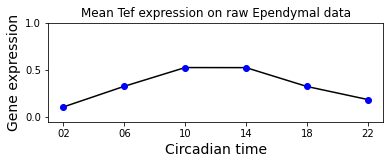

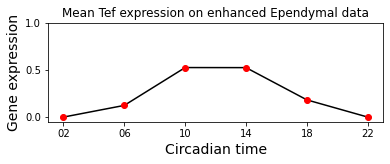

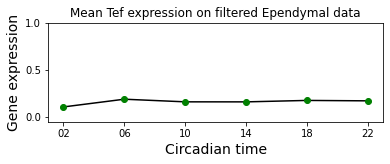

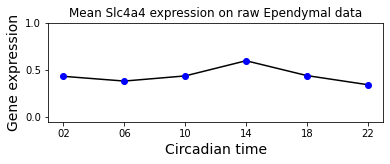

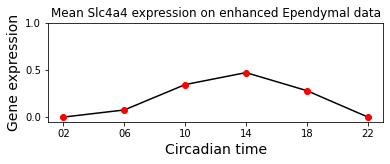

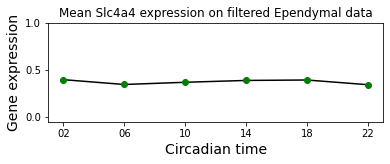

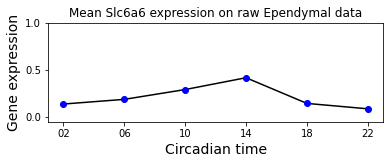

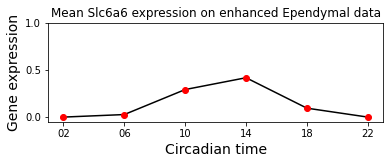

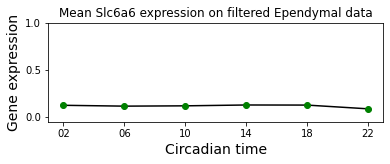

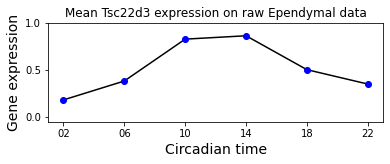

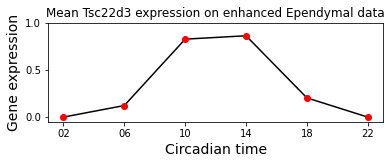

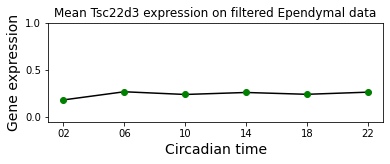

In [220]:
inner_product_genes_scn('Ependymal','Tef','Tsc22d3')
plt_mean_gene('Ependymal','Tef',up_lim=1, down_lim=-0.05)
plt_mean_gene('Ependymal','Slc4a4',up_lim=1, down_lim=-0.05)
plt_mean_gene('Ependymal','Slc6a6',up_lim=1, down_lim=-0.05)
plt_mean_gene('Ependymal','Tsc22d3',up_lim=1, down_lim=-0.05)

Ependymal


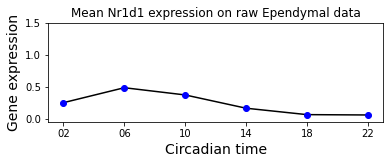

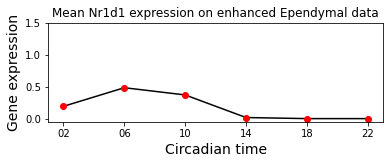

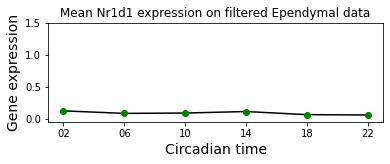

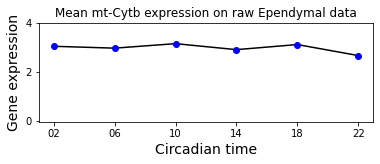

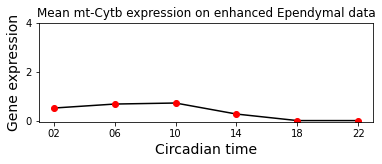

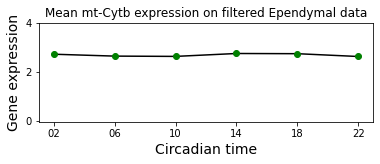

Enhanced data, TF: Nr1d1 target: mt-Cytb improtance: 50.902146887447344
Raw data, TF: Nr1d1 target: mt-Cytb improtance: 0.1995532206986753


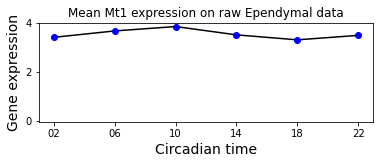

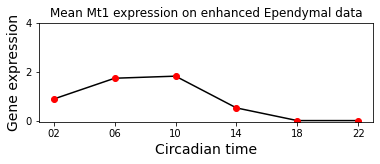

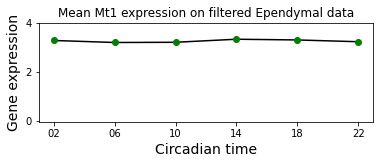

Enhanced data, TF: Nr1d1 target: Mt1 improtance: 43.20452730663154
Raw data, TF: Nr1d1 target: Mt1 improtance: 0.2135476966875656


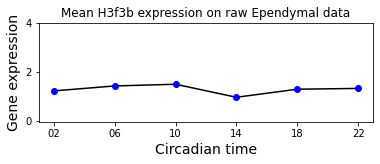

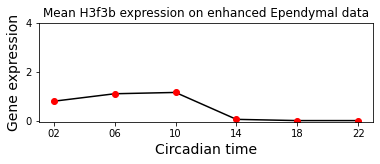

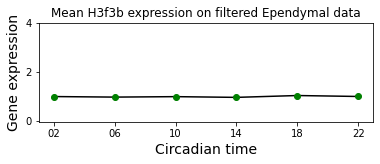

Enhanced data, TF: Nr1d1 target: H3f3b improtance: 38.37037751385219
Raw data, TF: Nr1d1 target: H3f3b improtance: 0.6247789201956091


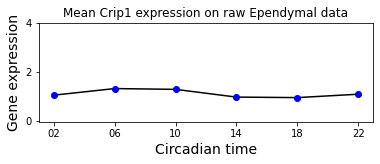

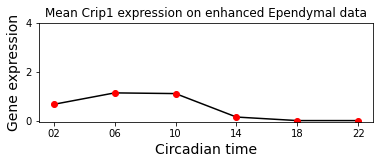

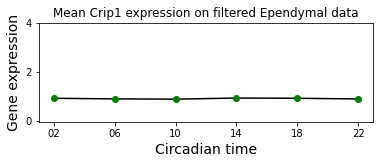

Enhanced data, TF: Nr1d1 target: Crip1 improtance: 29.631088903719174
Raw data, TF: Nr1d1 target: Crip1 improtance: 0


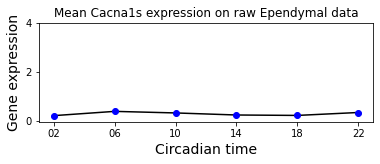

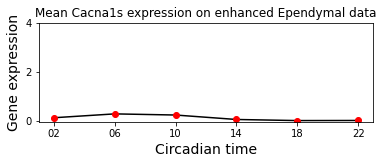

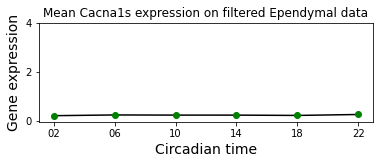

Enhanced data, TF: Nr1d1 target: Cacna1s improtance: 24.228550463051647
Raw data, TF: Nr1d1 target: Cacna1s improtance: 0


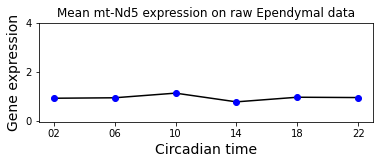

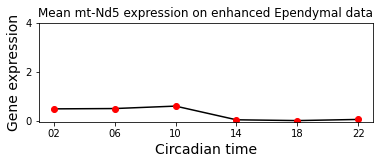

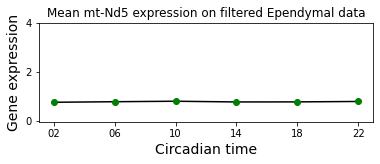

Enhanced data, TF: Nr1d1 target: mt-Nd5 improtance: 14.968728011375347
Raw data, TF: Nr1d1 target: mt-Nd5 improtance: 0.2026904745553437


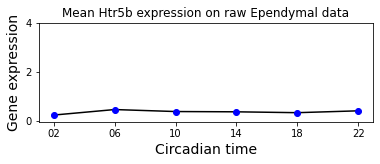

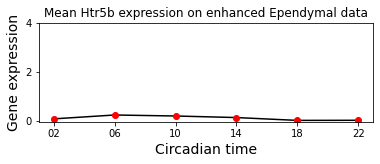

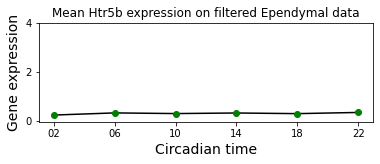

Enhanced data, TF: Nr1d1 target: Htr5b improtance: 12.832903261833277
Raw data, TF: Nr1d1 target: Htr5b improtance: 0


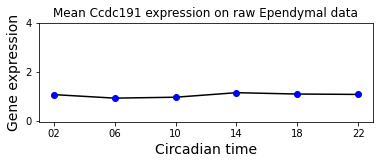

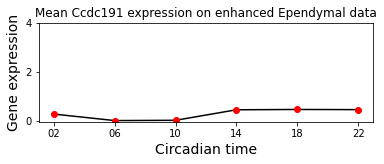

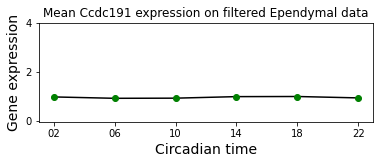

Enhanced data, TF: Nr1d1 target: Ccdc191 improtance: 10.532450556348133
Raw data, TF: Nr1d1 target: Ccdc191 improtance: 0.1975410418244369


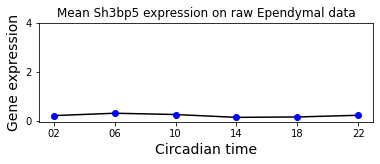

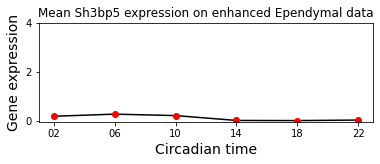

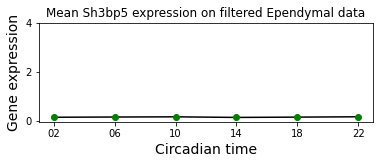

Enhanced data, TF: Nr1d1 target: Sh3bp5 improtance: 8.518053331466088
Raw data, TF: Nr1d1 target: Sh3bp5 improtance: 0.1128636093428476


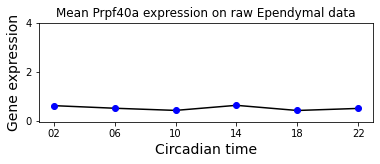

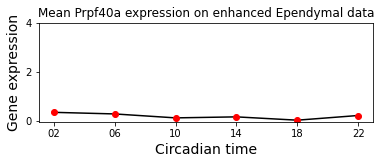

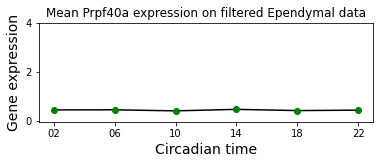

Enhanced data, TF: Nr1d1 target: Prpf40a improtance: 7.4510667155240995
Raw data, TF: Nr1d1 target: Prpf40a improtance: 0.1156627046664408


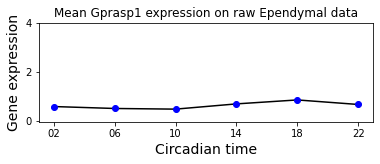

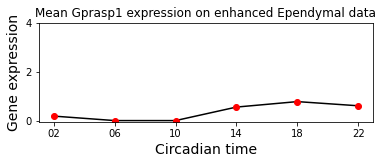

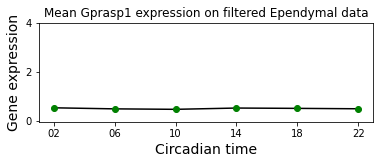

Enhanced data, TF: Nr1d1 target: Gprasp1 improtance: 7.361515481437024
Raw data, TF: Nr1d1 target: Gprasp1 improtance: 0


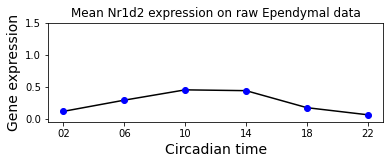

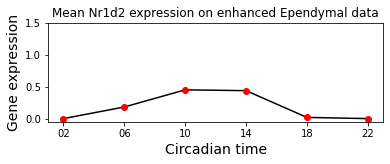

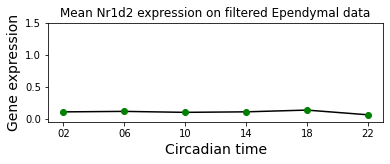

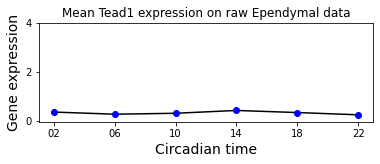

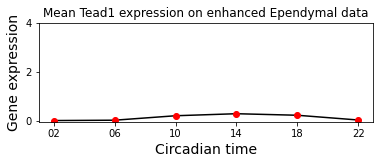

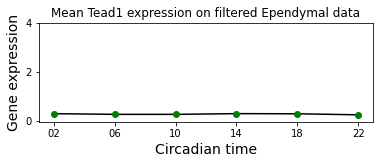

Enhanced data, TF: Nr1d2 target: Tead1 improtance: 13.037939524760713
Raw data, TF: Nr1d2 target: Tead1 improtance: 0.2199275623879055


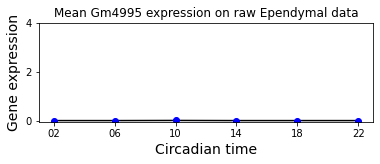

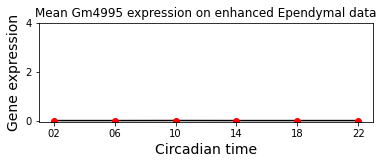

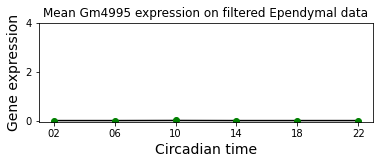

Enhanced data, TF: Nr1d2 target: Gm4995 improtance: 8.398103193309488
Raw data, TF: Nr1d2 target: Gm4995 improtance: 0.0617335494223356


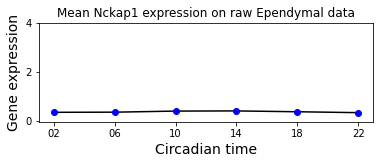

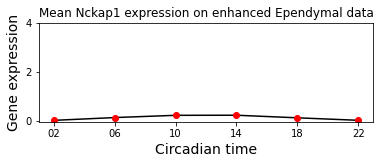

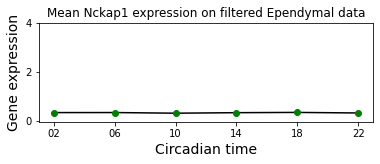

Enhanced data, TF: Nr1d2 target: Nckap1 improtance: 6.669366231590379
Raw data, TF: Nr1d2 target: Nckap1 improtance: 0.0872530740029668


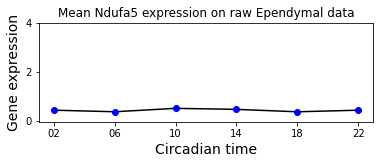

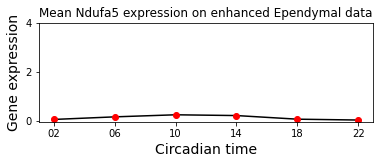

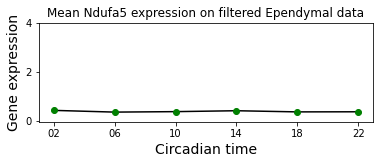

Enhanced data, TF: Nr1d2 target: Ndufa5 improtance: 6.182573599023733
Raw data, TF: Nr1d2 target: Ndufa5 improtance: 0.0452611651527434


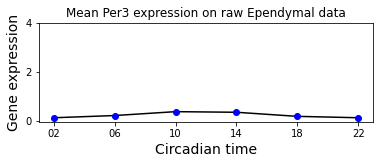

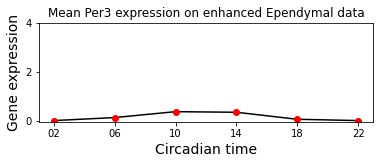

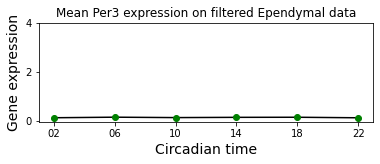

Enhanced data, TF: Nr1d2 target: Per3 improtance: 5.669798883066588
Raw data, TF: Nr1d2 target: Per3 improtance: 1.1435988179135456e-08


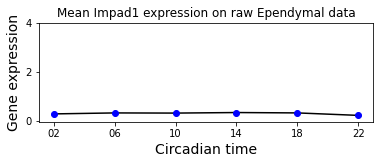

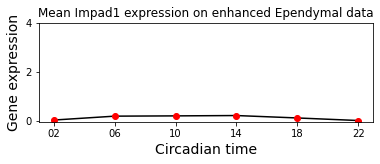

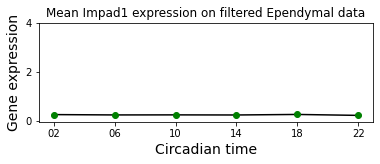

Enhanced data, TF: Nr1d2 target: Impad1 improtance: 5.624894744153946
Raw data, TF: Nr1d2 target: Impad1 improtance: 0.0002512983489797


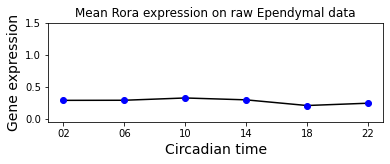

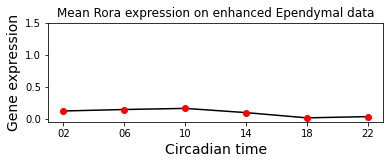

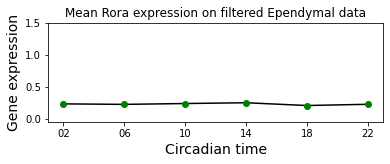

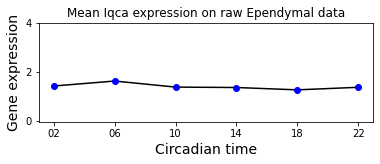

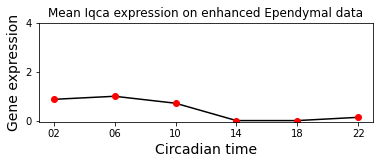

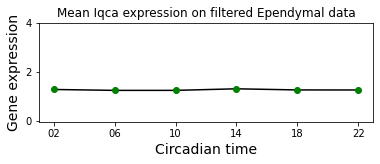

Enhanced data, TF: Rora target: Iqca improtance: 22.217290453020546
Raw data, TF: Rora target: Iqca improtance: 0.3443102746137301


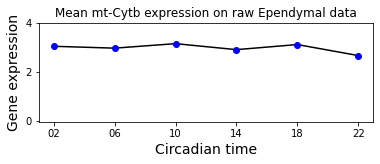

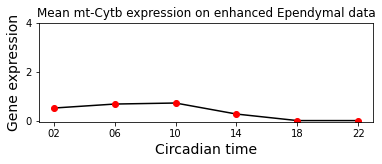

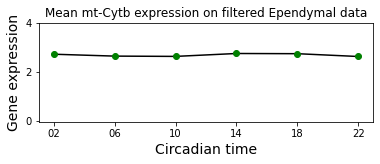

Enhanced data, TF: Rora target: mt-Cytb improtance: 19.638847829591903
Raw data, TF: Rora target: mt-Cytb improtance: 1.1530622171849036e-06


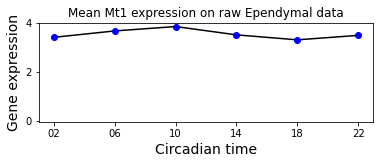

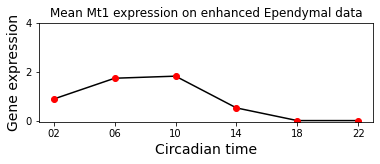

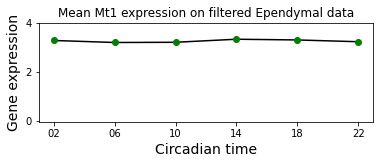

Enhanced data, TF: Rora target: Mt1 improtance: 18.46419899298305
Raw data, TF: Rora target: Mt1 improtance: 0.0596267609541482


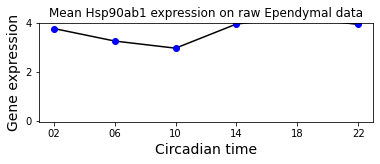

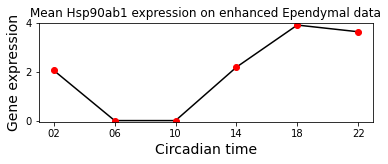

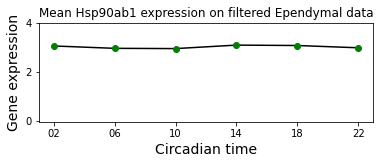

Enhanced data, TF: Rora target: Hsp90ab1 improtance: 16.44858119162292
Raw data, TF: Rora target: Hsp90ab1 improtance: 0.0691550791775443


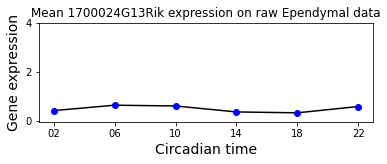

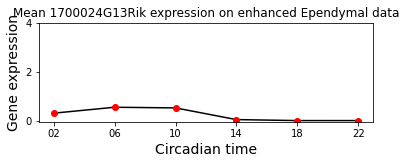

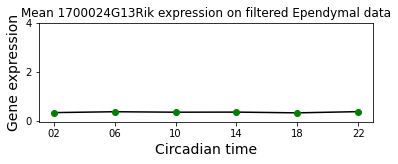

Enhanced data, TF: Rora target: 1700024G13Rik improtance: 11.192334665988652
Raw data, TF: Rora target: 1700024G13Rik improtance: 0


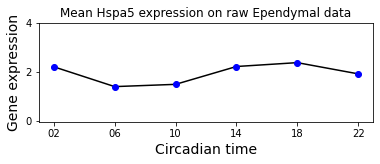

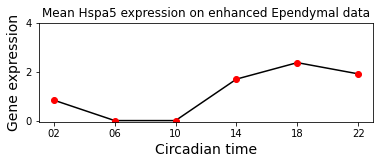

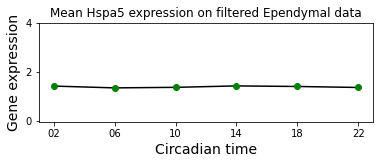

Enhanced data, TF: Rora target: Hspa5 improtance: 11.017611486989404
Raw data, TF: Rora target: Hspa5 improtance: 0


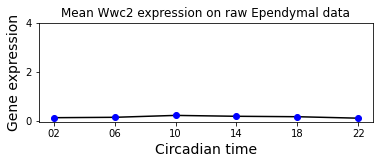

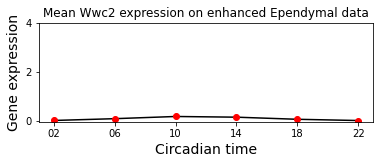

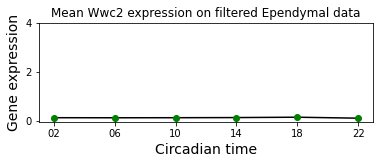

Enhanced data, TF: Rora target: Wwc2 improtance: 10.323712431536212
Raw data, TF: Rora target: Wwc2 improtance: 0.1607416964945477


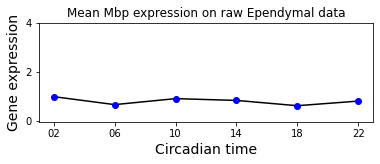

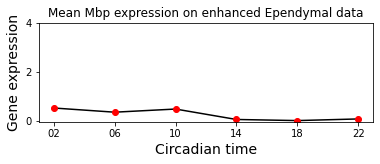

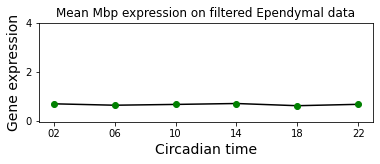

Enhanced data, TF: Rora target: Mbp improtance: 9.001135612277462
Raw data, TF: Rora target: Mbp improtance: 0


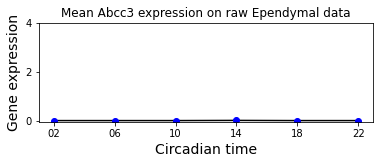

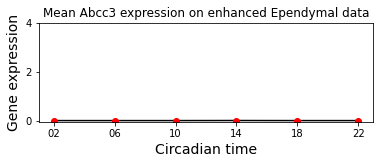

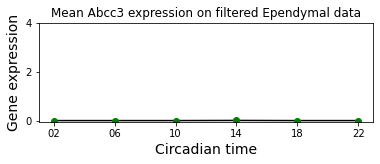

Enhanced data, TF: Rora target: Abcc3 improtance: 8.573195396572428
Raw data, TF: Rora target: Abcc3 improtance: 0.1457113342876323


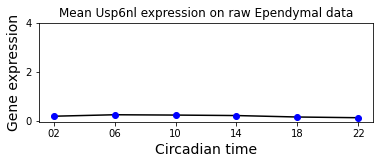

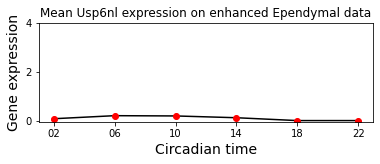

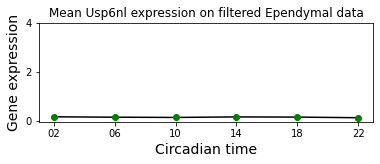

Enhanced data, TF: Rora target: Usp6nl improtance: 7.2099124217705235
Raw data, TF: Rora target: Usp6nl improtance: 0.1114967035107628


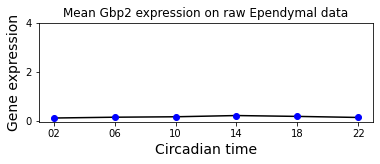

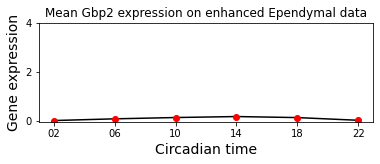

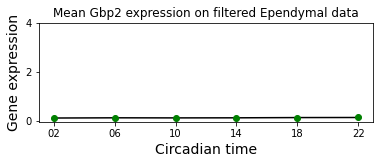

Enhanced data, TF: Rora target: Gbp2 improtance: 6.975616277283917
Raw data, TF: Rora target: Gbp2 improtance: 0.1214424463797501


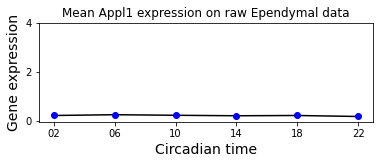

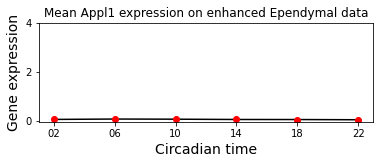

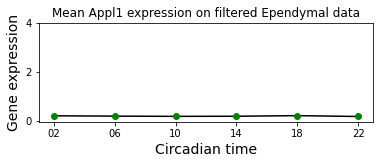

Enhanced data, TF: Rora target: Appl1 improtance: 5.1524620767109965
Raw data, TF: Rora target: Appl1 improtance: 0


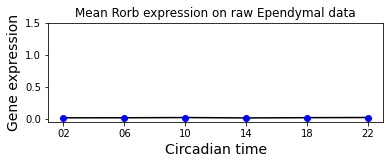

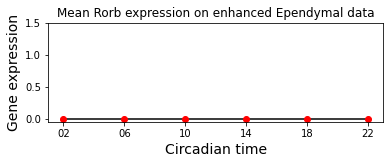

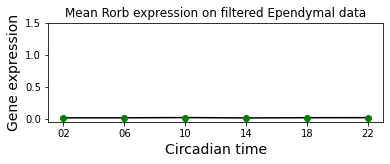

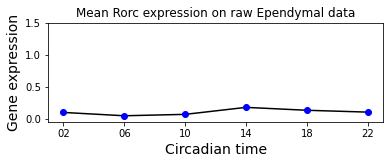

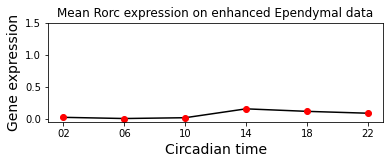

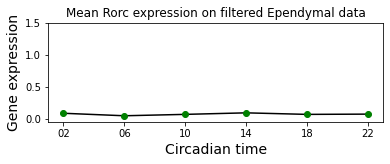

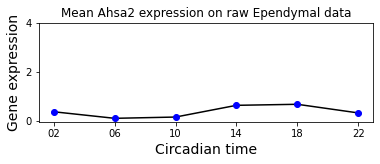

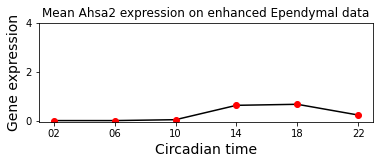

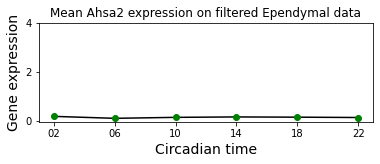

Enhanced data, TF: Rorc target: Ahsa2 improtance: 6.341185841716894
Raw data, TF: Rorc target: Ahsa2 improtance: 0


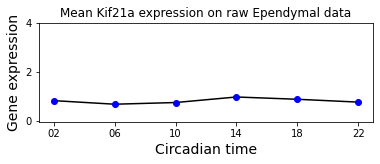

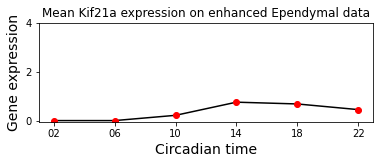

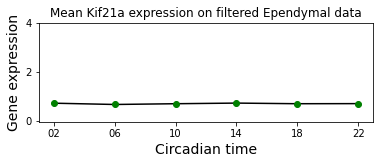

Enhanced data, TF: Rorc target: Kif21a improtance: 6.231301444666446
Raw data, TF: Rorc target: Kif21a improtance: 0


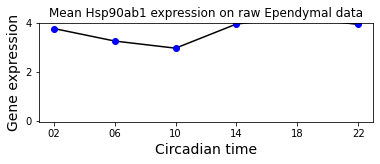

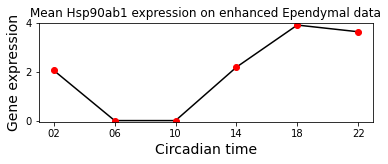

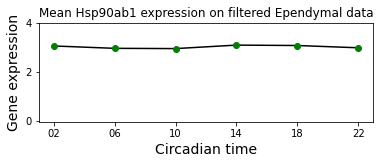

Enhanced data, TF: Rorc target: Hsp90ab1 improtance: 5.731274033048013
Raw data, TF: Rorc target: Hsp90ab1 improtance: 0.0700995866066038


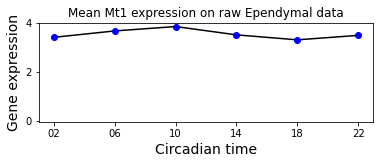

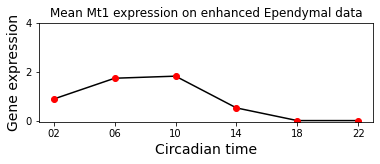

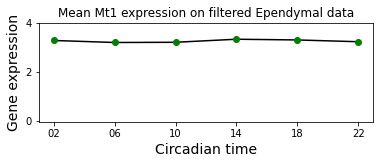

Enhanced data, TF: Rorc target: Mt1 improtance: 5.002840873392372
Raw data, TF: Rorc target: Mt1 improtance: 0


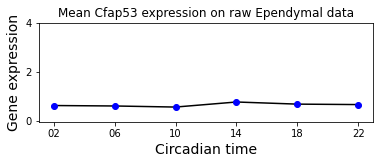

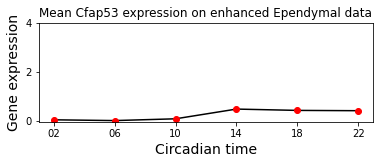

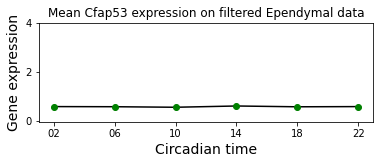

Enhanced data, TF: Rorc target: Cfap53 improtance: 4.930455543953604
Raw data, TF: Rorc target: Cfap53 improtance: 0


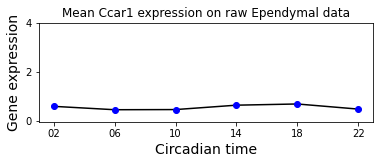

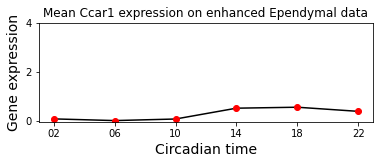

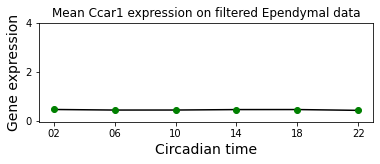

Enhanced data, TF: Rorc target: Ccar1 improtance: 4.581460460445447
Raw data, TF: Rorc target: Ccar1 improtance: 0


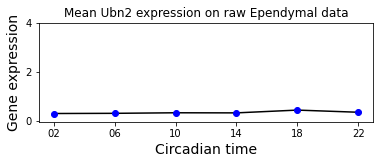

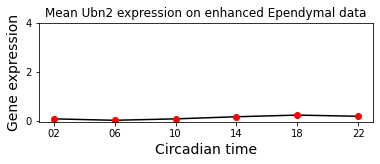

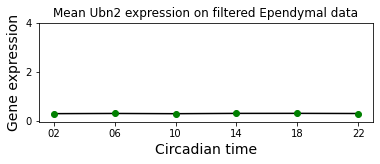

Enhanced data, TF: Rorc target: Ubn2 improtance: 4.522229715401156
Raw data, TF: Rorc target: Ubn2 improtance: 0


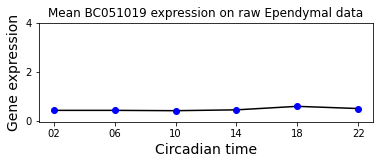

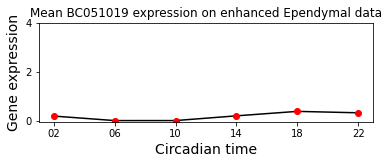

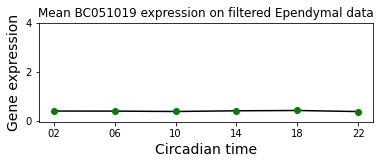

Enhanced data, TF: Rorc target: BC051019 improtance: 4.1427753441585375
Raw data, TF: Rorc target: BC051019 improtance: 0


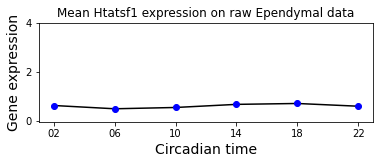

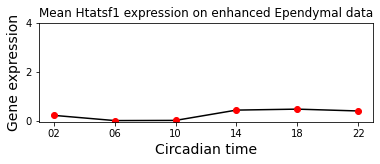

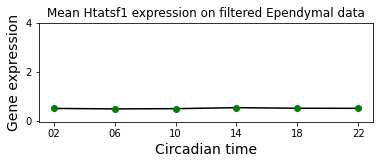

Enhanced data, TF: Rorc target: Htatsf1 improtance: 3.815366717890045
Raw data, TF: Rorc target: Htatsf1 improtance: 0.015305564621961


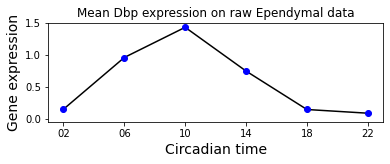

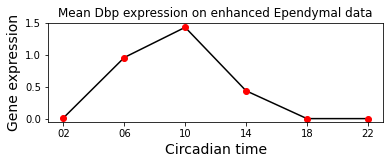

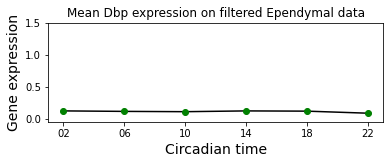

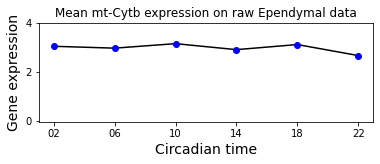

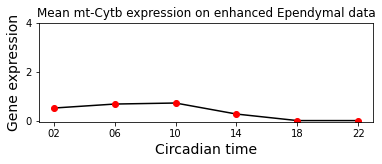

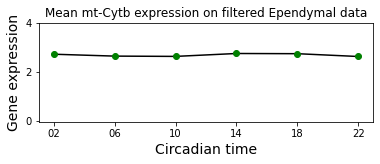

Enhanced data, TF: Dbp target: mt-Cytb improtance: 94.0420366127024
Raw data, TF: Dbp target: mt-Cytb improtance: 0.9057573643949276


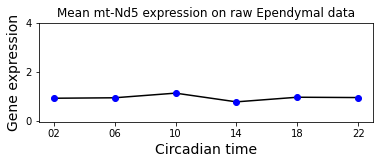

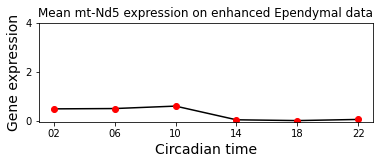

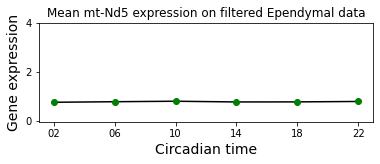

Enhanced data, TF: Dbp target: mt-Nd5 improtance: 40.08127326717219
Raw data, TF: Dbp target: mt-Nd5 improtance: 0.2368776986726656


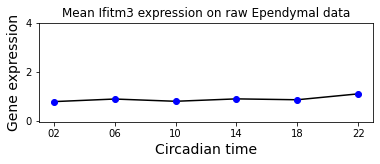

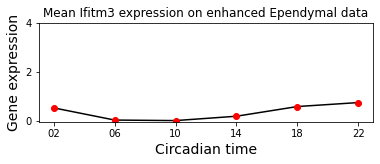

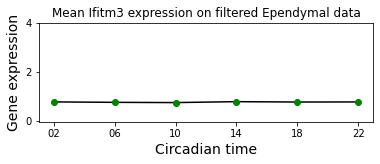

Enhanced data, TF: Dbp target: Ifitm3 improtance: 32.35198379831955
Raw data, TF: Dbp target: Ifitm3 improtance: 0.5045407302808864


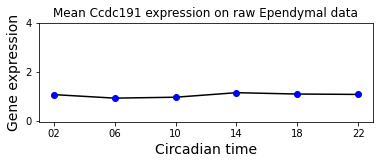

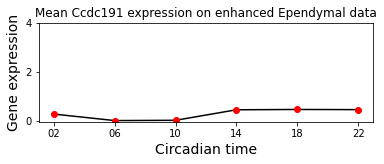

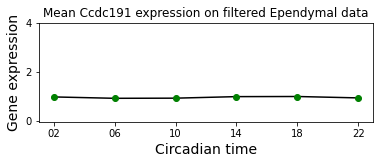

Enhanced data, TF: Dbp target: Ccdc191 improtance: 27.738405310338173
Raw data, TF: Dbp target: Ccdc191 improtance: 0.2445513869186706


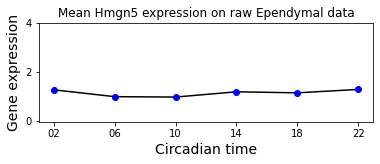

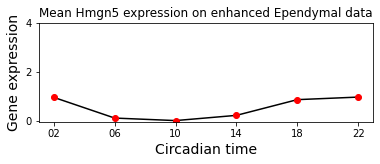

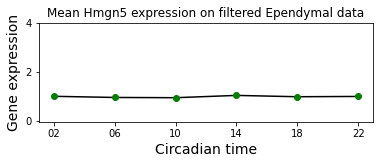

Enhanced data, TF: Dbp target: Hmgn5 improtance: 23.79633029161808
Raw data, TF: Dbp target: Hmgn5 improtance: 0.2623238882710263


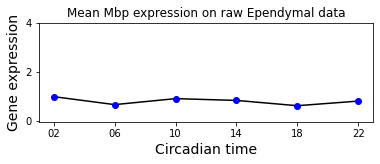

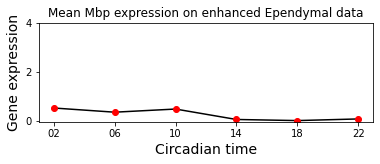

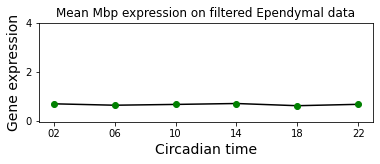

Enhanced data, TF: Dbp target: Mbp improtance: 22.83494398841708
Raw data, TF: Dbp target: Mbp improtance: 0.146569995532714


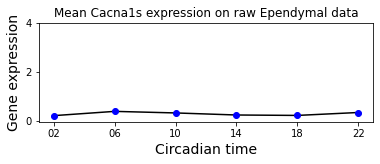

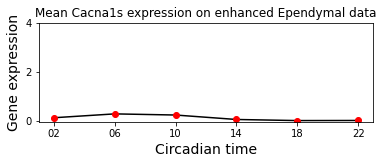

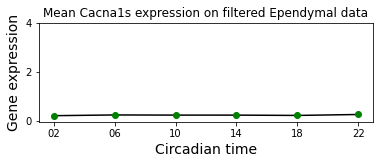

Enhanced data, TF: Dbp target: Cacna1s improtance: 21.90115115328308
Raw data, TF: Dbp target: Cacna1s improtance: 0.4061334729221402


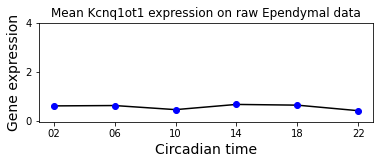

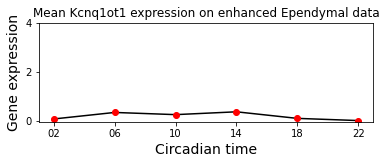

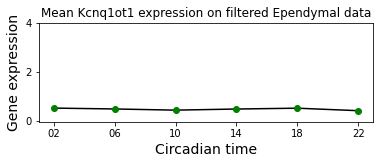

Enhanced data, TF: Dbp target: Kcnq1ot1 improtance: 21.69948647358792
Raw data, TF: Dbp target: Kcnq1ot1 improtance: 0.3382372759415101


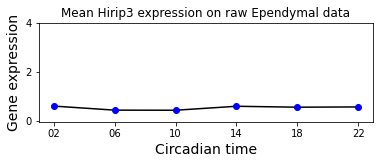

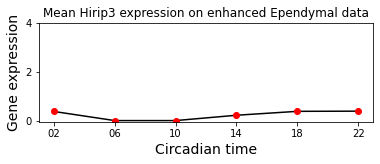

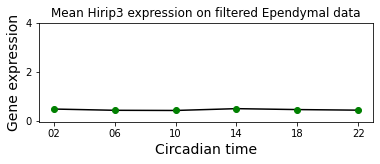

Enhanced data, TF: Dbp target: Hirip3 improtance: 21.02020136617845
Raw data, TF: Dbp target: Hirip3 improtance: 0.2486753979974458


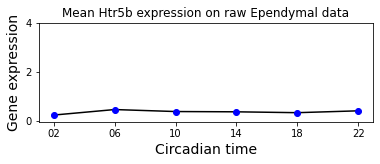

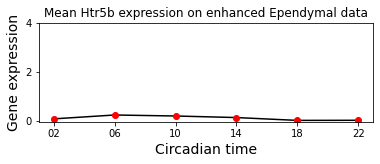

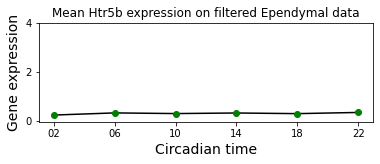

Enhanced data, TF: Dbp target: Htr5b improtance: 20.904126883965365
Raw data, TF: Dbp target: Htr5b improtance: 0.2122908203244206


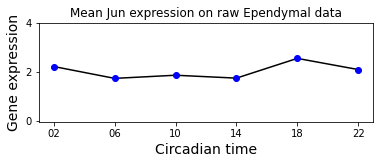

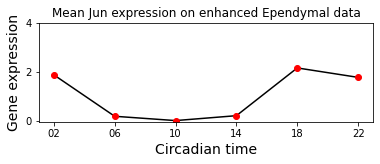

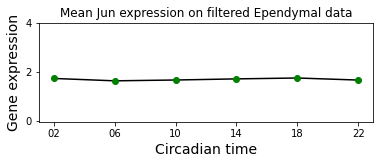

Enhanced data, TF: Dbp target: Jun improtance: 20.66529372115416
Raw data, TF: Dbp target: Jun improtance: 0.0887261714609519


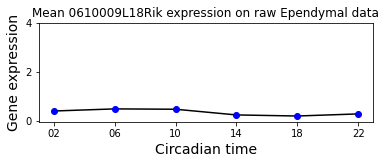

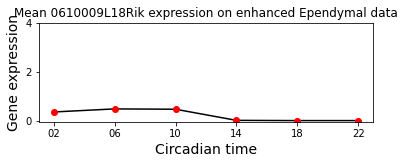

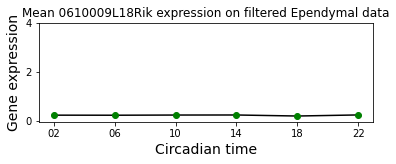

Enhanced data, TF: Dbp target: 0610009L18Rik improtance: 20.211881454151804
Raw data, TF: Dbp target: 0610009L18Rik improtance: 0


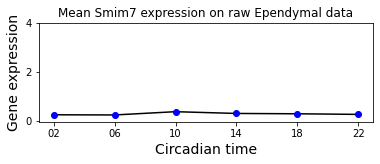

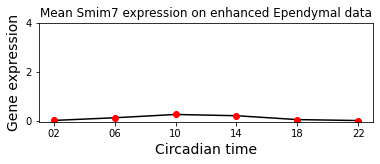

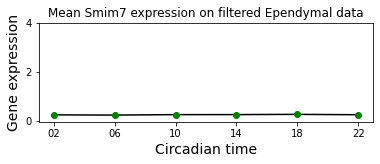

Enhanced data, TF: Dbp target: Smim7 improtance: 18.79022553981952
Raw data, TF: Dbp target: Smim7 improtance: 0.1179568411635866


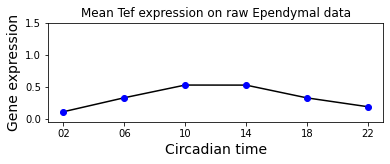

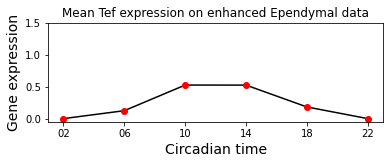

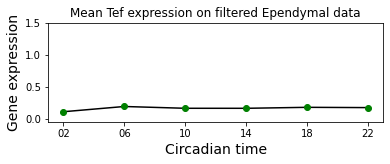

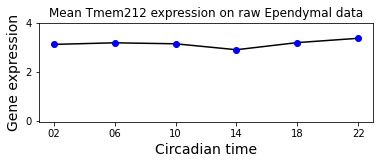

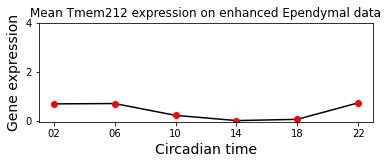

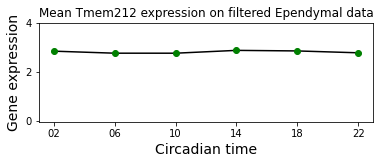

Enhanced data, TF: Tef target: Tmem212 improtance: 20.9867766233804
Raw data, TF: Tef target: Tmem212 improtance: 0.0973317797523049


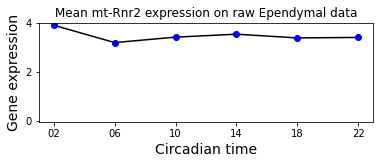

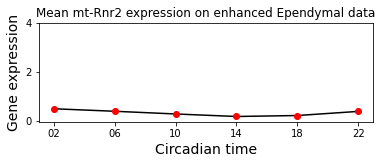

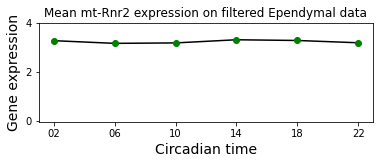

Enhanced data, TF: Tef target: mt-Rnr2 improtance: 16.9897077413995
Raw data, TF: Tef target: mt-Rnr2 improtance: 0


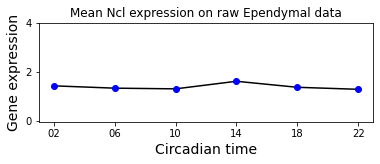

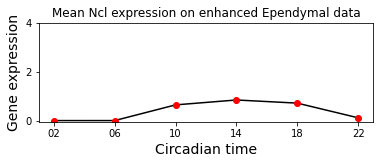

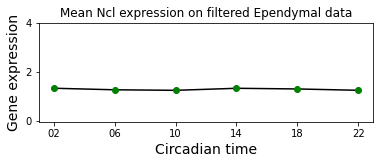

Enhanced data, TF: Tef target: Ncl improtance: 16.31272701903573
Raw data, TF: Tef target: Ncl improtance: 0.0878050092385154


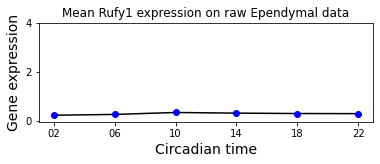

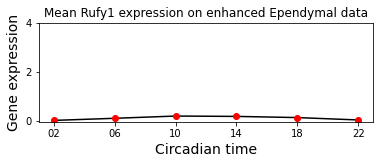

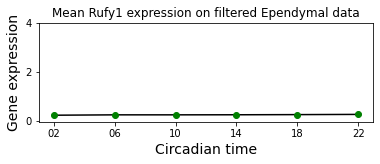

Enhanced data, TF: Tef target: Rufy1 improtance: 13.56779862884895
Raw data, TF: Tef target: Rufy1 improtance: 0.2057037443913331


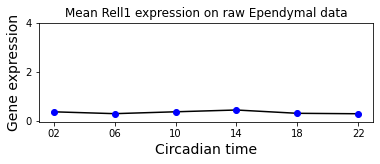

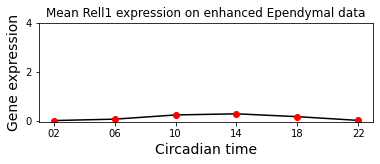

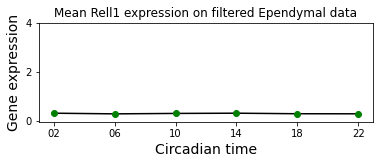

Enhanced data, TF: Tef target: Rell1 improtance: 13.4281565362997
Raw data, TF: Tef target: Rell1 improtance: 0.0866449475133952


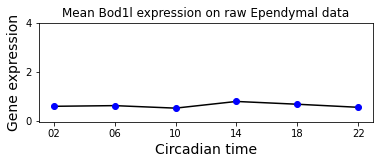

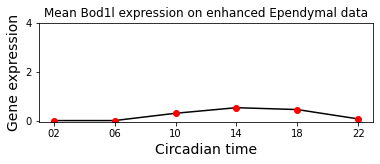

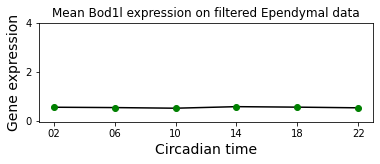

Enhanced data, TF: Tef target: Bod1l improtance: 12.687909028584064
Raw data, TF: Tef target: Bod1l improtance: 0.0804156834939164


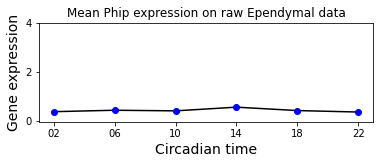

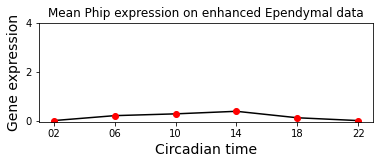

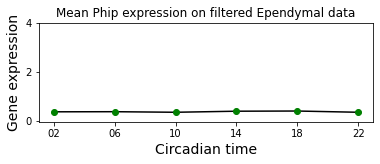

Enhanced data, TF: Tef target: Phip improtance: 9.93134277611927
Raw data, TF: Tef target: Phip improtance: 0.1936247831635703


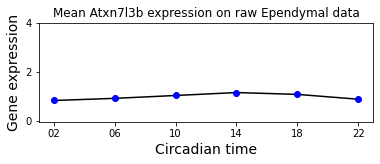

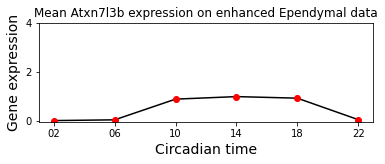

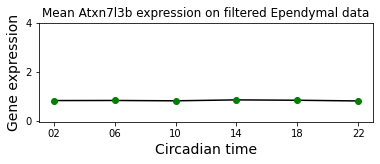

Enhanced data, TF: Tef target: Atxn7l3b improtance: 9.78869848183023
Raw data, TF: Tef target: Atxn7l3b improtance: 0.0294331940652134


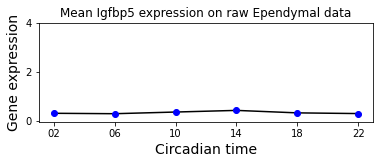

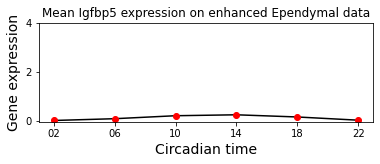

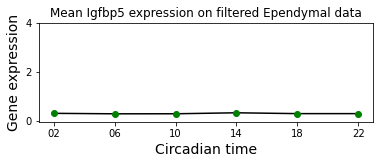

Enhanced data, TF: Tef target: Igfbp5 improtance: 9.479048088793984
Raw data, TF: Tef target: Igfbp5 improtance: 0.1152741593256635


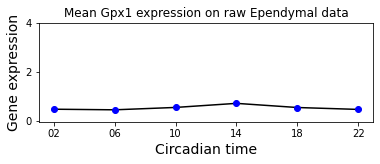

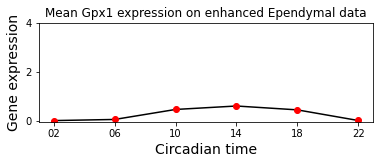

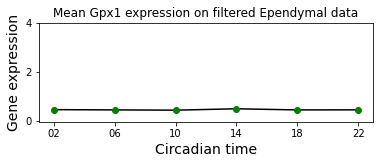

Enhanced data, TF: Tef target: Gpx1 improtance: 9.438609240308107
Raw data, TF: Tef target: Gpx1 improtance: 0.1484738857184183


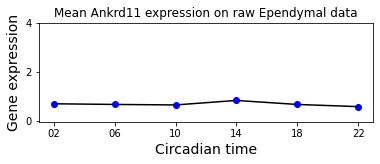

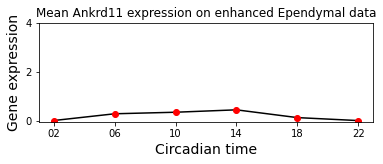

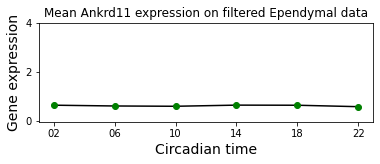

Enhanced data, TF: Tef target: Ankrd11 improtance: 7.825803247926234
Raw data, TF: Tef target: Ankrd11 improtance: 0.0565610792802697


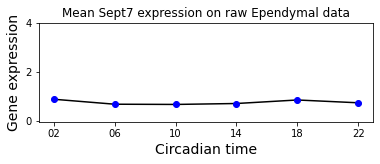

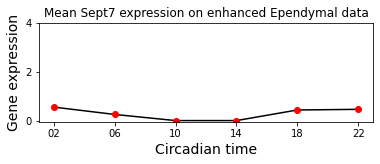

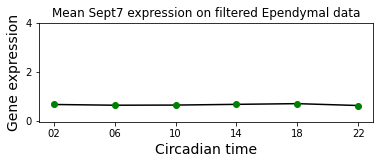

Enhanced data, TF: Tef target: Sept7 improtance: 7.705277262021336
Raw data, TF: Tef target: Sept7 improtance: 0.1392077880387686


In [52]:
def calculate_tf_scores(cluster,network_en,network_raw):
    circadian_tf_list = ['Nr1d1','Nr1d2','Rora','Rorb','Rorc','Dbp','Tef']
    for item in circadian_tf_list:
        plt_mean_gene(cluster,item,up_lim=1.5, down_lim=-0.05)
        tf_en_df =  network_en.loc[((network_en['TF'] == item)) ]
        tf_raw_df =  network_raw.loc[((network_raw['TF'] == item))] 
        i=0
        for index, row in tf_en_df.iterrows():
            i+=1
            if i >50:
                break
            if row['target'] in tf_raw_df['target'].values:
                tmp_row = tf_raw_df.loc[((tf_raw_df['target'] == row['target'])) ]
                importance=float(tmp_row['importance'])
            else:
                importance=0
            if float(row['importance']) > importance*50:
                plt_mean_gene(cluster,row['target'],up_lim=4, down_lim=-0.05)
                print("Enhanced data, TF: " +item + " target: " + row['target'] + " improtance: " +str( row['importance']))
                print("Raw data, TF: " +item + " target: " + row['target'] + " improtance: " +str( importance))

cluster1 = [
    'Ependymal',
    'NG2',
    'Endothelial',
    'Astrocytes',
    'Microglia',
    'Tanycytes',
    'Oligodendrocytes',
    'Neurons2']
for cluster in cluster1:
    network_en = pd.read_csv('SCN/' + cluster + '_netowrk_en_tf.csv')  
    network_raw = pd.read_csv('SCN/' + cluster + '_netowrk_raw_tf.csv')  
    print(cluster)
    calculate_tf_scores(cluster,network_en,network_raw)


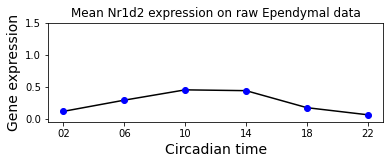

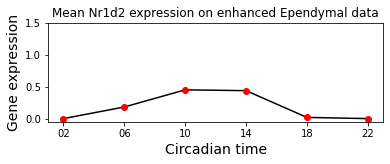

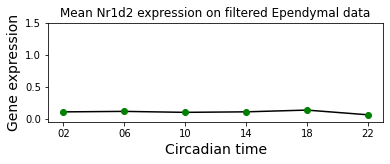

KeyError: 'Tef-1'

In [58]:
plt_mean_gene(cluster,'Nr1d2',up_lim=1.5, down_lim=-0.05)
plt_mean_gene(cluster,'Tef-1',up_lim=1.5, down_lim=-0.05)
plt_mean_gene(cluster,'Gm4995',up_lim=0.05, down_lim=-0.01)
plt_mean_gene(cluster,'Nckap1',up_lim=0.5, down_lim=-0.05)
plt_mean_gene(cluster,'Ndufa5',up_lim=1.0, down_lim=-0.05)


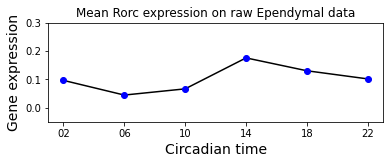

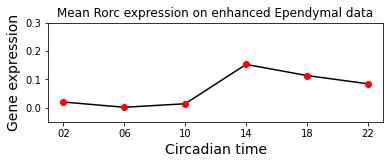

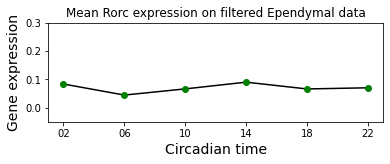

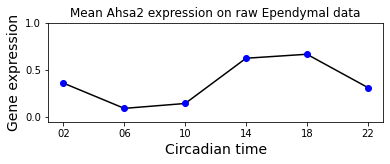

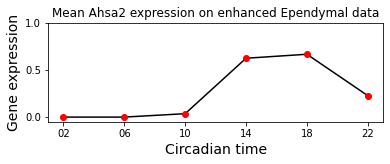

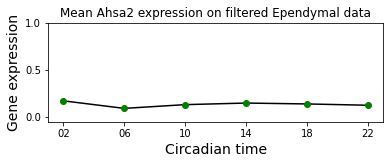

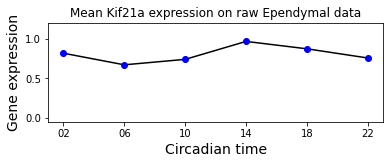

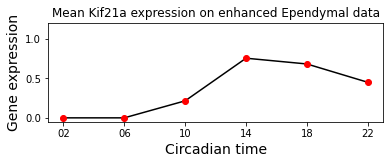

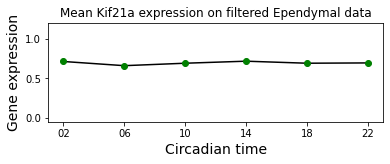

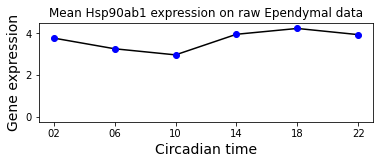

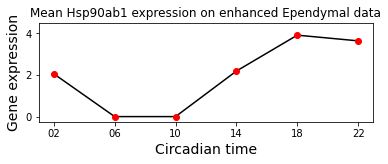

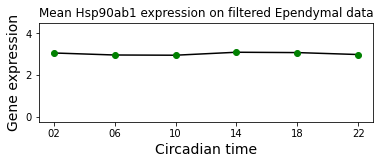

In [72]:
plt_mean_gene('Ependymal','Rorc',up_lim=0.3, down_lim=-0.05)
plt_mean_gene('Ependymal','Ahsa2',up_lim=1, down_lim=-0.05)
plt_mean_gene('Ependymal','Kif21a',up_lim=1.2, down_lim=-0.05)
plt_mean_gene('Ependymal','Hsp90ab1',up_lim=4.5, down_lim=-0.25)